<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Thedin-Bandara/sarima_jumper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#SAFRIMA
#Seasonal AutoRegressive Fractionally Integrated Moving Average

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
from google.colab import drive

In [3]:
# Mounting the Google Drive
drive.mount('/content/drive')

# Reading the data from the excel file and removing blank spaces in each cell
# data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/preprocessed_data_new.xlsx')

data = '/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/preprocessed_data_new.xlsx'

data = pd.read_excel(data)

Mounted at /content/drive


In [4]:
# Specify the file path
!ls -l $file_path
file_path = 'preprocessed_data_new.xlsx'

data = pd.read_excel(file_path)

total 8
drwx------ 6 root root 4096 Mar 16 16:17 drive
drwxr-xr-x 1 root root 4096 Mar 14 13:27 sample_data


FileNotFoundError: [Errno 2] No such file or directory: 'preprocessed_data_new.xlsx'

In [5]:
# Define a mapping of sub-departments to main departments
sub_dept_to_main_dept = {
    'Jumper Team': [sub_dept for sub_dept in data['Department'] if sub_dept.startswith('Jumper Team')]
}


# Map each sub-department to its main department
main_dept_for_sub_dept = {}
for main_dept, sub_depts in sub_dept_to_main_dept.items():
    for sub_dept in sub_depts:
        main_dept_for_sub_dept[sub_dept] = main_dept

# Add a new column indicating the main department for each row
data['MainDepartment'] = data['Department'].map(main_dept_for_sub_dept)


In [6]:
#main department all leaves
leave_days_by_month = data.groupby(['LeaveYear', 'LeaveMonth', 'MainDepartment']).size().reset_index(name='TotalLeaveDays')
print(leave_days_by_month)

    LeaveYear  LeaveMonth MainDepartment  TotalLeaveDays
0        2021          12    Jumper Team             111
1        2022           1    Jumper Team              91
2        2022           2    Jumper Team             131
3        2022           3    Jumper Team             188
4        2022           4    Jumper Team             120
5        2022           5    Jumper Team             189
6        2022           6    Jumper Team             151
7        2022           7    Jumper Team             114
8        2022           8    Jumper Team             135
9        2022           9    Jumper Team             131
10       2022          10    Jumper Team             142
11       2022          11    Jumper Team             136
12       2022          12    Jumper Team              96
13       2023           1    Jumper Team             102
14       2023           2    Jumper Team              81
15       2023           3    Jumper Team             107
16       2023           4    Ju

ADF Statistic: -1.2660295708242042
p-value: 0.6445670445764196
Critical Values:
   1%: -3.7529275211638033
   5%: -2.998499866852963
   10%: -2.6389669754253307


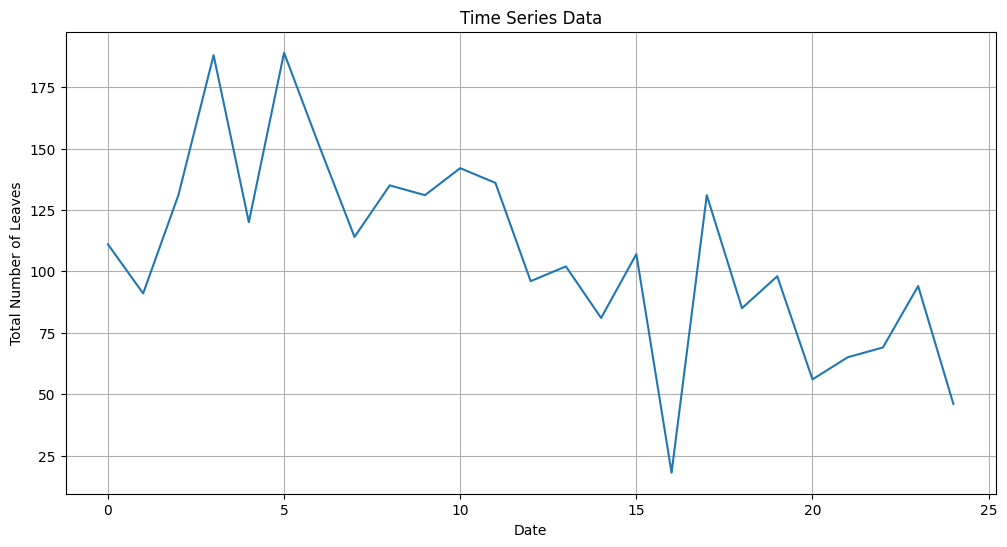

In [7]:
def adf_test(timeseries):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

adf_test(leave_days_by_month['TotalLeaveDays'])

# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(leave_days_by_month['TotalLeaveDays'])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Total Number of Leaves')
plt.grid(True)
plt.show()

In [8]:
# Step 3: Split Data
train_size = int(len(leave_days_by_month) * 0.9)
train_data, test_data = leave_days_by_month['TotalLeaveDays'][:train_size], leave_days_by_month['TotalLeaveDays'][train_size:]


In [9]:
train_data.head()

0    111
1     91
2    131
3    188
4    120
Name: TotalLeaveDays, dtype: int64

In [10]:
# Step 4: Build and Train SARFIMA Model
order = (2, 1, 1)  # Example SARIMA parameters (p, d, q)
seasonal_order = (1, 1, 1, 5)  # Example seasonal parameters (P, D, Q, S)
sarima_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, trend='c', enforce_stationarity=False)
trained_model = sarima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


22    65.075924
23    78.466549
24    61.275794
Name: predicted_mean, dtype: float64
Mean Squared Error: 163.34544810683994
Root Mean Squared Error (RMSE): 12.780666966431758


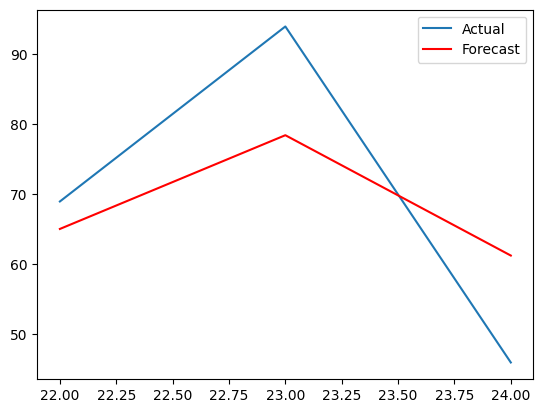

In [11]:
# Step 5: Validate Model
forecast = trained_model.forecast(steps=3)
print(forecast)
# Step 6: Evaluate Model
mse = mean_squared_error(test_data, forecast)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Visualize Results
plt.plot(test_data, label='Actual')
plt.plot(forecast, color='red', label='Forecast')
plt.legend()
plt.show()

import pickle

# Save the model to a file
file_path = '/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Models/Jumper_sarimax.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(trained_model, f)

In [12]:
import pickle
file_path = '/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Models/Jumper_sarimax.pkl'
with open(file_path, 'wb') as f: pickle.dump(trained_model, f)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

order = (2, 1, 1)  # Example SARIMA parameters (p, d, q)
seasonal_order = (1, 1, 1, 5)  # Example seasonal parameters (P, D, Q, S)

# Function to evaluate ARIMA model
def evaluate_arima(train, test, order):
    # Fit ARIMA model
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    # Calculate MSE and RMSE
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)

    return forecast, mse, rmse

# Function to evaluate ETS model
def evaluate_ets(train, test, seasonal_periods):
    # Fit ETS model
    model = ExponentialSmoothing(train)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    # Calculate MSE and RMSE
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)

    return forecast, mse, rmse

# Function to evaluate SARIMA model
def evaluate_sarima(train, test, order, seasonal_order):
    # Fit SARIMA model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    # Calculate MSE and RMSE
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)

    return forecast, mse, rmse

# Split data into train and test sets
train = leave_days_by_month['TotalLeaveDays'].iloc[:train_size]
test = leave_days_by_month['TotalLeaveDays'].iloc[train_size:]

# Evaluate ARIMA model
arima_forecast, arima_mse, arima_rmse = evaluate_arima(train, test, order)

# Evaluate ETS model
seasonal_periods = 12
ets_forecast, ets_mse, ets_rmse = evaluate_ets(train, test, seasonal_periods)

# Evaluate SARIMA model
sarima_forecast, sarima_mse, sarima_rmse = evaluate_sarima(train, test, order, seasonal_order)


# Displaying the MSE and RMSE for each model
print("ARIMA Model:")
print("MSE:", arima_mse)
print("RMSE:", arima_rmse)
print()

print("ETS (Exponential Smoothing) Model:")
print("MSE:", ets_mse)
print("RMSE:", ets_rmse)
print()

print("SARIMA Model:")
print("MSE:", sarima_mse)
print("RMSE:", sarima_rmse)
print()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


ARIMA Model:
MSE: 391.9558209127479
RMSE: 19.7978741513514

ETS (Exponential Smoothing) Model:
MSE: 435.48396298130547
RMSE: 20.868252513837987

SARIMA Model:
MSE: 150.79171322079605
RMSE: 12.279727733984824



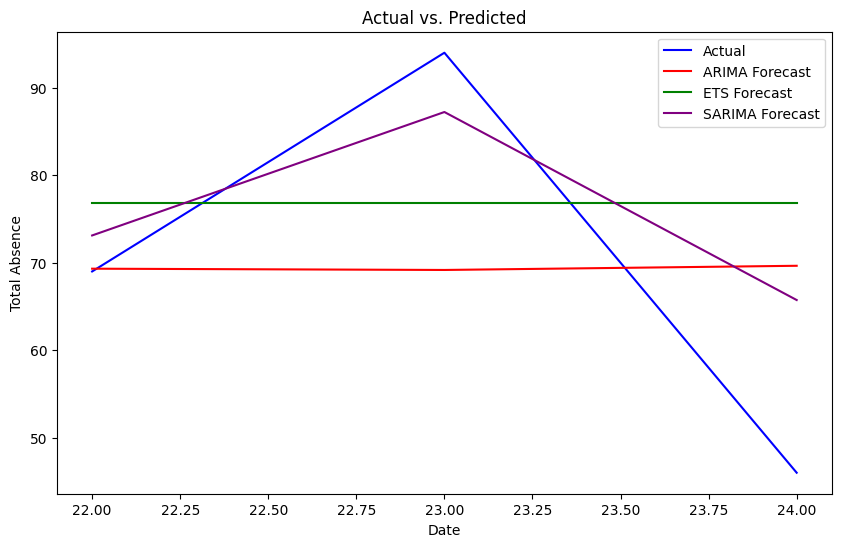

In [18]:
# Plotting actual vs. predicted values for all models
plt.figure(figsize=(10, 6))
plt.plot(test.index, test.values, label='Actual', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(test.index, ets_forecast, label='ETS Forecast', color='green')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='purple')
plt.title('Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Total Absence')
plt.legend()
plt.show()